# Red recurrente Imperative/Training loop
- Objetivo: Programar una RNN en notación orientada a objetos con Tensorflow 2.0

- Referencia Imperative APIs: https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html

Los modelos son más personalizables para tareas como investigación

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import imdb



from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
# numero de palabras
num_words = 10000

max_len = 59
embedding_dim = 128

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)


x_train = pad_sequences(x_train, maxlen=max_len, padding = 'post')
x_test = pad_sequences(x_test, maxlen=max_len, padding = 'post')


print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000, 59)
(25000, 59)
(25000,)
(25000,)


In [3]:
batch_size = 50

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)

In [4]:
print('Reseña')
print(x_train[0])
print('Etiqueta')
print(y_train[0])

Reseña
[  13  104   88    4  381   15  297   98   32 2071   56   26  141    6
  194 7486   18    4  226   22   21  134  476   26  480    5  144   30
 5535   18   51   36   28  224   92   25  104    4  226   65   16   38
 1334   88   12   16  283    5   16 4472  113  103   32   15   16 5345
   19  178   32]
Etiqueta
1


In [5]:
wordDict = {y:x for x,y in imdb.get_word_index().items()}  
res = []
for index in x_train[0]:
    res.append(wordDict.get(index - 3))
print('Reseña: ',res,'Longitud reseña: ', len(res))

Reseña:  ['i', 'think', 'because', 'the', 'stars', 'that', 'play', 'them', 'all', 'grown', 'up', 'are', 'such', 'a', 'big', 'profile', 'for', 'the', 'whole', 'film', 'but', 'these', 'children', 'are', 'amazing', 'and', 'should', 'be', 'praised', 'for', 'what', 'they', 'have', 'done', "don't", 'you', 'think', 'the', 'whole', 'story', 'was', 'so', 'lovely', 'because', 'it', 'was', 'true', 'and', 'was', "someone's", 'life', 'after', 'all', 'that', 'was', 'shared', 'with', 'us', 'all'] Longitud reseña:  59


# Crear modelo


In [6]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import Model

In [7]:
class RNN(Model):
    def __init__(self):
        super(RNN, self).__init__()
        self.embedding = Embedding(num_words, embedding_dim)
        self.lstm = LSTM(128)
        self.d = Dense(1, activation='sigmoid')

    def call(self, x): # método call que pasa 'x' por capa
        x = self.embedding(x)
        x = self.lstm(x)
        return self.d(x)


In [8]:
model = RNN()
model.build( input_shape=(None, max_len))
model.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1280000   
_________________________________________________________________
lstm (LSTM)                  multiple                  131584    
_________________________________________________________________
dense (Dense)                multiple                  129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [9]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [10]:
train_loss = tf.keras.metrics.BinaryCrossentropy(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

In [11]:
hist_loss = []
hist_acc = []

# Entrenamiento
- Se hace un ciclo por épocas en donde se itera por cada época sobre cada par de datos y etiquetas de entrenamiento

- *Nota: El entrenamiento con 'tf.function decorator' tiene un mejor desempeño al compilarse en grafo. Para simplificar el ejemplo, también se omite el entrenamiento en conjunto de prueba*

In [12]:
EPOCH = 10
for epoch in range(EPOCH):
    #entrenamiento
    for data, target in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(data)# predicciones
            loss = loss_fn(target, predictions) # target y predicciones para obtener acc
        gradients = tape.gradient(loss, model.trainable_variables) # gradiente sobre variables entrenables
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # se guardan metricas
        train_loss(target, predictions)
        train_accuracy(target, predictions)
    

    template = 'Epoch {}/{} \n - loss: {} - accuracy: {}'
    print(template.format(epoch+1, EPOCH,
                        train_loss.result(), train_accuracy.result()))
    # lista para plot
    hist_loss.append(train_loss.result())
    hist_acc.append(train_accuracy.result())
    # reinicia las metricas para la siguiente epoca
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch 1/10 
 - loss: 0.44712960720062256 - accuracy: 0.7866796255111694
Epoch 2/10 
 - loss: 0.2966446876525879 - accuracy: 0.8751993775367737
Epoch 3/10 
 - loss: 0.2211247831583023 - accuracy: 0.9112399220466614
Epoch 4/10 
 - loss: 0.15693973004817963 - accuracy: 0.9388808608055115
Epoch 5/10 
 - loss: 0.10652169585227966 - accuracy: 0.9625210165977478
Epoch 6/10 
 - loss: 0.07776147872209549 - accuracy: 0.9723614454269409
Epoch 7/10 
 - loss: 0.05989265814423561 - accuracy: 0.9799212217330933
Epoch 8/10 
 - loss: 0.04978509992361069 - accuracy: 0.983401894569397
Epoch 9/10 
 - loss: 0.03153662383556366 - accuracy: 0.9897211790084839
Epoch 10/10 
 - loss: 0.02850654534995556 - accuracy: 0.9913609623908997


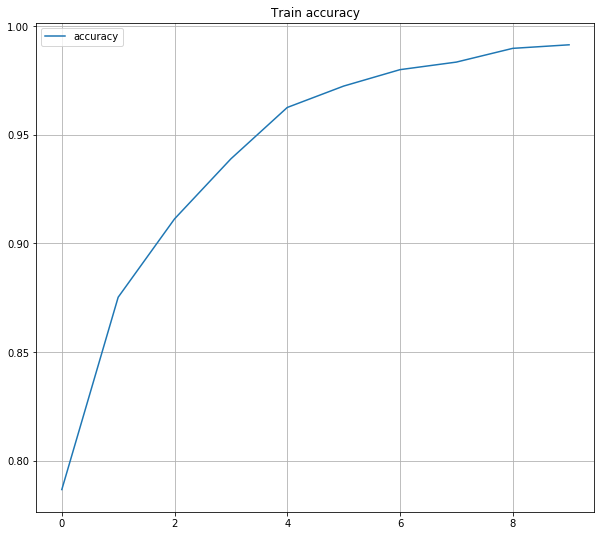

In [13]:
plt.figure(figsize=(10,9))
plt.plot(np.arange(len(hist_acc)), hist_acc)
plt.title('Train accuracy')
plt.legend(['accuracy'])
plt.grid()

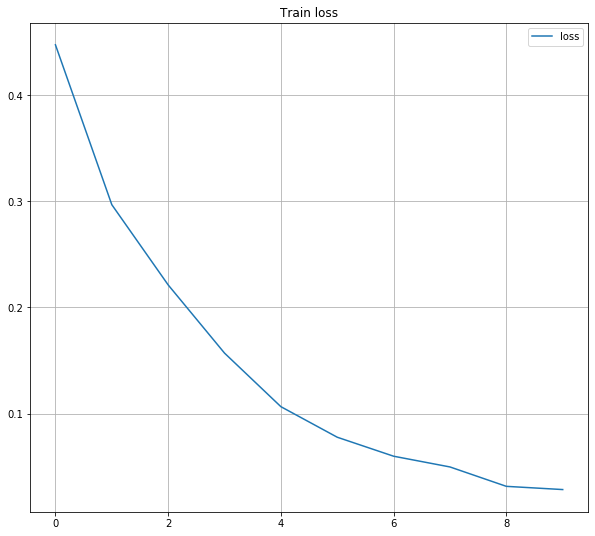

In [14]:
plt.figure(figsize=(10,9))
plt.plot(np.arange(len(hist_loss)), hist_loss)
plt.title('Train loss')
plt.legend(['loss'])
plt.grid()

- Personalizar la arquitectura
- Agregar conjunto de validación
- Mejorar el modelo